In [29]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from tqdm import tqdm_notebook

import os

import warnings
warnings.filterwarnings('ignore')

In [30]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

random_state=17

from scipy.stats import skew

In [126]:
data = pd.read_excel("AirQualityUCI.xlsx")
data.shape

(9357, 15)

But what makes a TS different from say a regular regression problem? There are 2 things:

    It is time dependent. So the basic assumption of a linear regression model 
    that the observations are independent doesn’t hold in this case.

     Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations 
     specific to a   particular time frame. 
     For example, if you see the sales of a woolen jacket over time, you 
     will invariably find higher sales in winter seasons.

In [127]:
data["Date"] = data["Date"].apply(lambda x: str(x)[:10] + " ")
data["Time"] = data["Time"].apply(lambda x: str(x))

data['Datetime'] = pd.to_datetime(data['Date'] + data["Time"])  
data['Datetime']

datetime = list(data["Datetime"].values)
data.index = datetime



In [128]:
data=data["C6H6(GT)"]

In [129]:
cdata = data[data != -200]
data=cdata

In [140]:
data.fillna(data.mean(),inplace=True)

In [146]:
data.describe()

count    8991.000000
mean       10.082993
std         7.449640
min         0.149048
25%         4.436942
50%         8.239851
75%        13.988478
max        63.741476
Name: C6H6(GT), dtype: float64

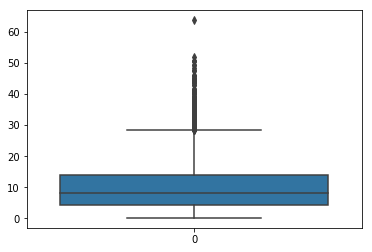

In [137]:
sns.boxplot(data=data)

In [ ]:
#data = data[data["C6H6(GT)"] < 40]

In [149]:
S1=data

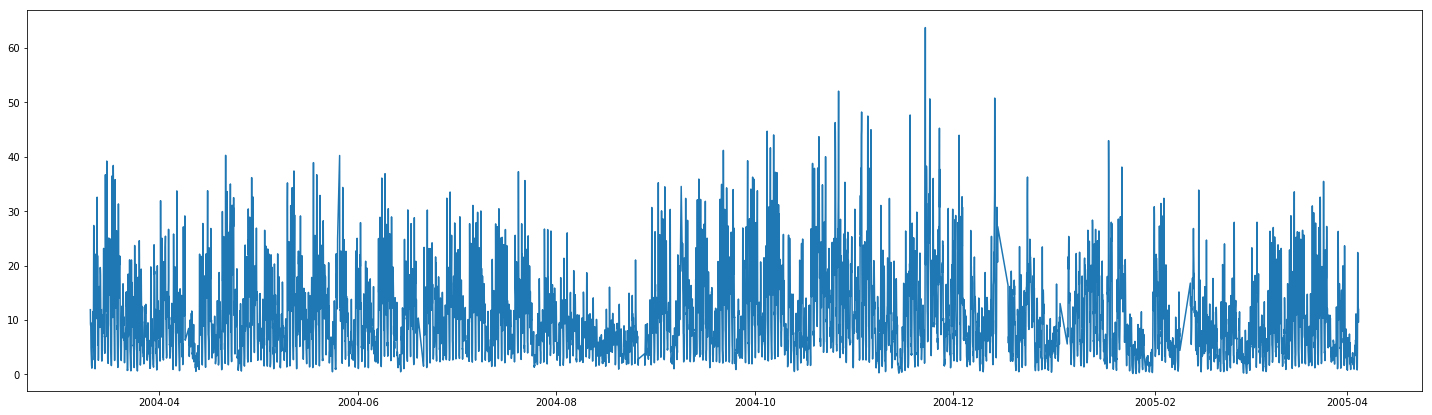

In [155]:
plt.figure(figsize=(25,7))
plt.plot(S1)

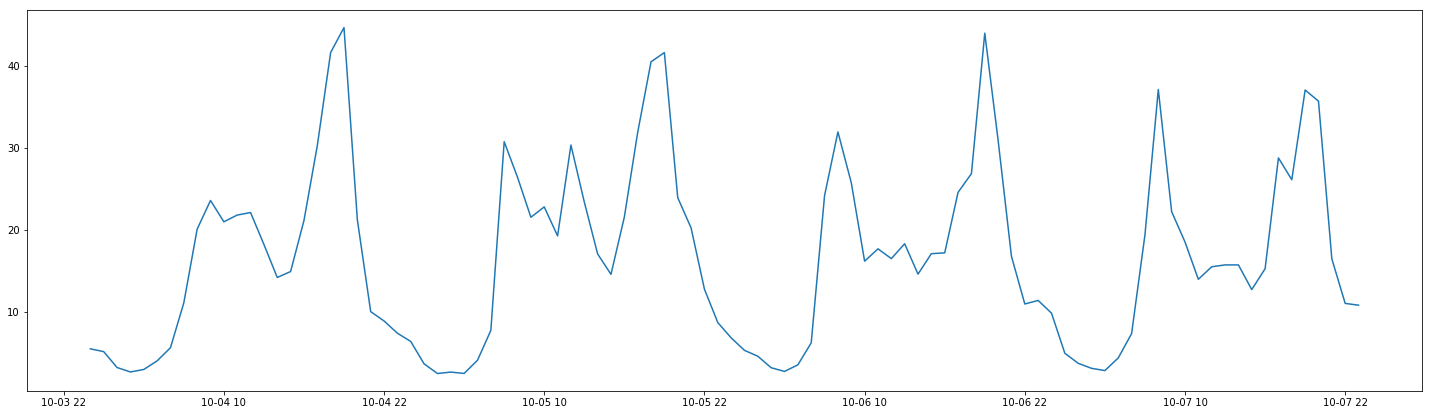

In [156]:
plt.figure(figsize=(25,7))
plt.plot(S1['2004-10-04':'2004-10-07'])
#3days

In [157]:
S1_lagged = S1.shift()

,lagged,real
lagged,1.000000,0.838212
real,0.838212,1.000000


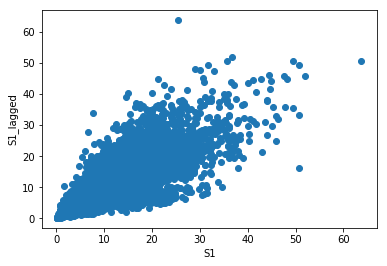

In [158]:
plt.scatter(S1, S1_lagged)
plt.xlabel('S1')
plt.ylabel('S1_lagged')
pd.DataFrame({'real': S1, 'lagged': S1_lagged}).corr()



check stationarity
The first step in applying ARIMA methodology is to check for stationarity. 

"Stationarity" implies that the series remains at a fairly constant level over time. If a trend exists, as in most economic or business applications, then your data is NOT stationary. 

The data should also show a constant variance in its fluctuations over time. This is easily seen with a series that is heavily seasonal and growing at a faster rate. In such a case, the ups and downs in the seasonality will become more dramatic over time. Without these stationarity conditions being met, many of the calculations associated with the process cannot be computed.

A time series is said to be weakly stationary if it has:
1. Constant mean over the time;
2. Constant variance over the time;
3. And its autocorrelation does not depend on the time.

In [178]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolloing statistics
    rolmean = pd.rolling_mean(timeseries, window = 24)
    rolstd = pd.rolling_std(timeseries, window=24)
    
    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot (timeseries, color='blue', label='Original',lw=0.2)
    mean = plt.plot (rolmean, color='red', label = 'Rolling Mean',lw=1)
    std = plt.plot (rolstd, color='black', label='Rolling Std',lw=0.2)
    plt.legend(loc='best')
    plt.title('rolling Mean & Statndard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

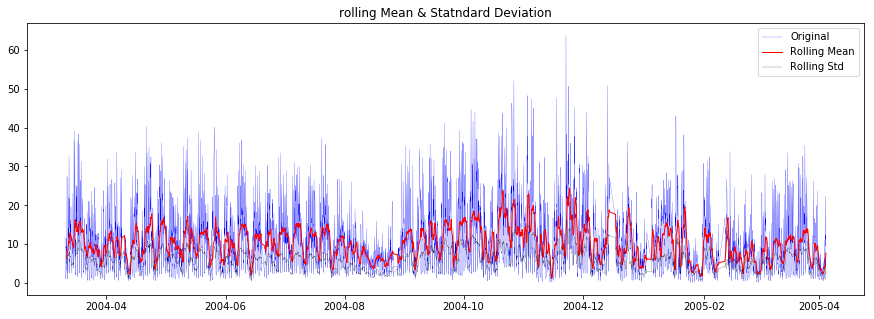

Results of Dickey-Fuller Test:
Test Statistic                -1.024821e+01
p-value                        4.558072e-18
#Lags Used                     3.700000e+01
Number of Observations Used    8.953000e+03
Critical Value (10%)          -2.566942e+00
Critical Value (1%)           -3.431081e+00
Critical Value (5%)           -2.861863e+00
dtype: float64


In [179]:
test_stationarity(S1)
#With nearly constant rolling mean and rolling variance, and with pvalue of DickeyFullerTest 
#close to zero, I can conclude that S1is weakly stationary

In [ ]:
If a graphical plot of the data indicates nonstationarity, then you should "difference" the series.
Differencing is an excellent way of transforming a nonstationary series to a stationary one. 
This is done by subtracting the observation in the current period from the previous one. 
If this transformation is done only once to a series, you say that the data has been "first differenced".
This process essentially eliminates the trend if your series is growing at a fairly constant rate.
If it is growing at an increasing rate, you can apply the same procedure
and difference the data again. Your data would then be "second differenced".

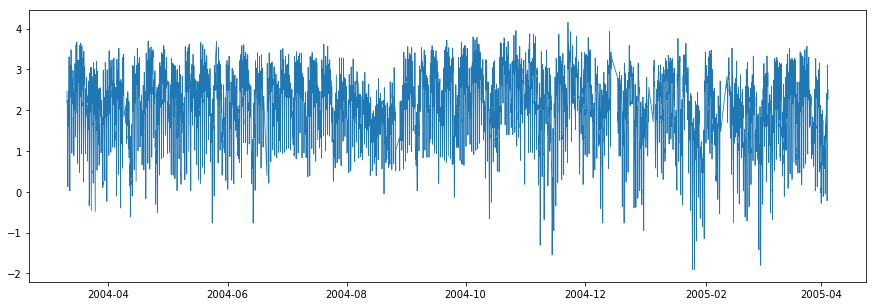

In [180]:
S1_log = np.log(S1)
plt.figure(figsize=(15,5))
plt.plot(S1_log,lw=0.8)

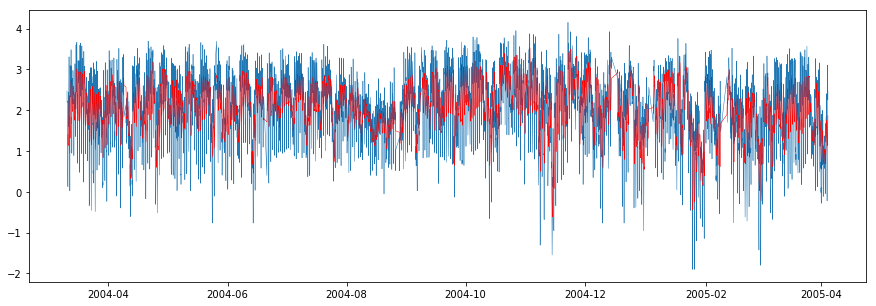

In [181]:
moving_avg = pd.rolling_mean(S1_log,12)
plt.figure(figsize=(15,5))
plt.plot(S1_log,lw=0.5)
plt.plot(moving_avg, color='red',lw=0.5)

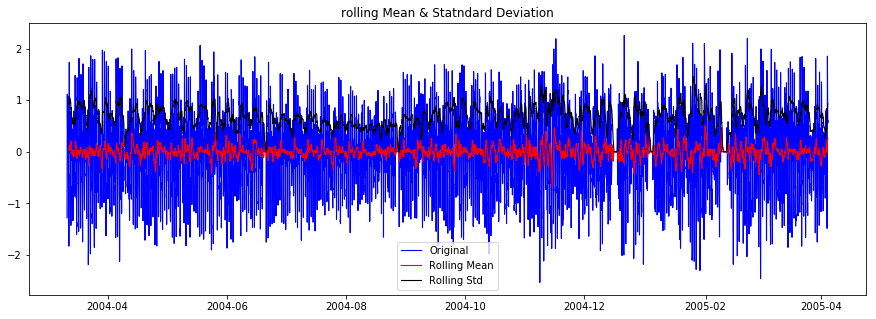

Results of Dickey-Fuller Test:
Test Statistic                  -19.464718
p-value                           0.000000
#Lags Used                       38.000000
Number of Observations Used    9275.000000
Critical Value (10%)             -2.566936
Critical Value (1%)              -3.431055
Critical Value (5%)              -2.861852
dtype: float64


In [57]:
ts_log_moving_avg_diff = S1_log - moving_avg
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

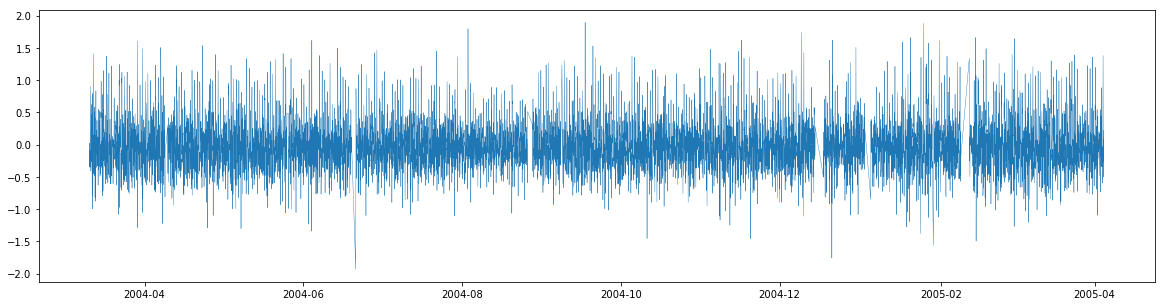

In [182]:
S1_log_diff = S1_log - S1_log.shift()
plt.figure(figsize=(20,5))
plt.plot(S1_log_diff,lw=0.4)

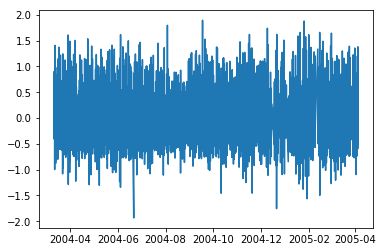

In [192]:
S1_log_diff = S1_log - S1_log.shift()
plt.plot(S1_log_diff)

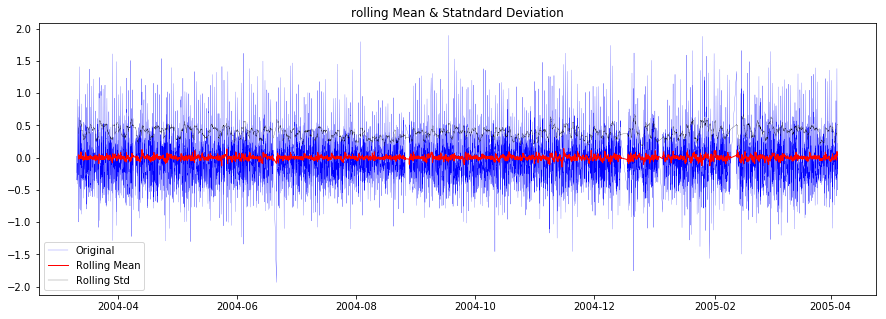

Results of Dickey-Fuller Test:
Test Statistic                  -19.283019
p-value                           0.000000
#Lags Used                       36.000000
Number of Observations Used    8953.000000
Critical Value (10%)             -2.566942
Critical Value (1%)              -3.431081
Critical Value (5%)              -2.861863
dtype: float64


In [193]:
S1_log_diff.dropna(inplace=True)
test_stationarity(S1_log_diff)

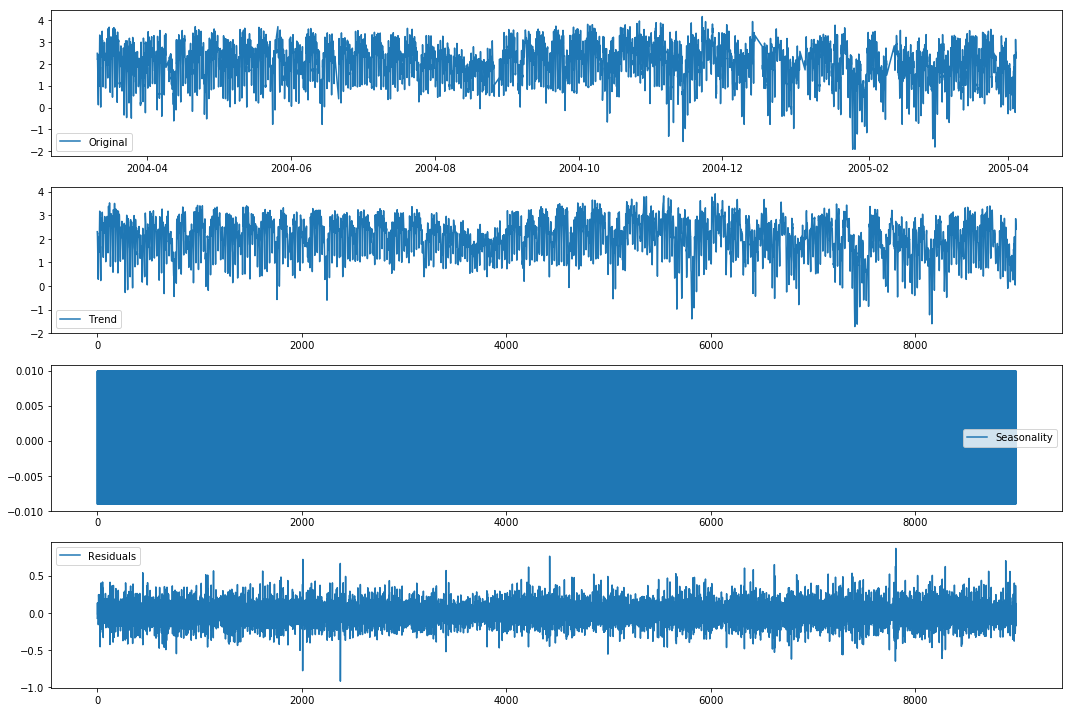

In [186]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.asarray(S1_log), freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(S1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

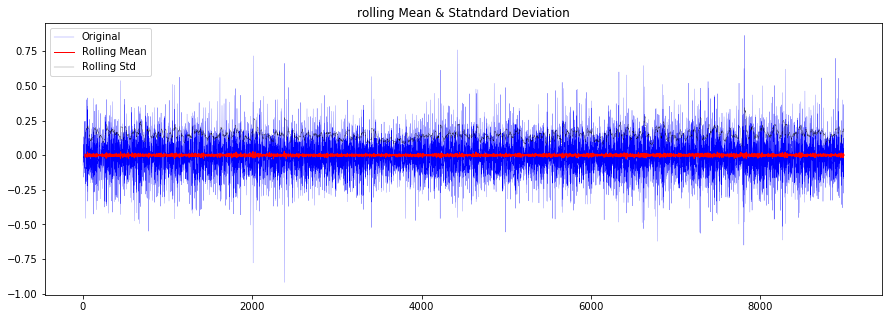

Results of Dickey-Fuller Test:
Test Statistic                  -32.237613
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8951.000000
Critical Value (10%)             -2.566942
Critical Value (1%)              -3.431081
Critical Value (5%)              -2.861863
dtype: float64


In [187]:
Residue = pd.DataFrame(data=residual,index=data.index)
Residue.dropna(inplace=True)
S1_log_decompose = Residue
S1_log_decompose = S1_log_decompose.iloc[:,0].values
test_stationarity(S1_log_decompose)

In [188]:
S1_log_decompose = Residue
S1_log_decompose.head()

,0
2004-03-10 19:00:00,-0.073636
2004-03-10 20:00:00,-0.022021
2004-03-10 21:00:00,0.133369
2004-03-10 22:00:00,-0.019706
2004-03-10 23:00:00,-0.015693


In [189]:
S1_log_decompose.describe()

,0
count,8989.000000
mean,-0.000018
std,0.149746
min,-0.918110
25%,-0.089768
50%,-0.002672
75%,0.088310
max,0.864635


In [190]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [194]:
lag_acf = acf(S1_log_diff, nlags=24)
lag_pacf = pacf(S1_log_diff, nlags=24, method='ols')

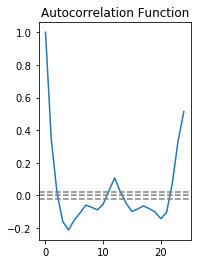

In [195]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(S1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(S1_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

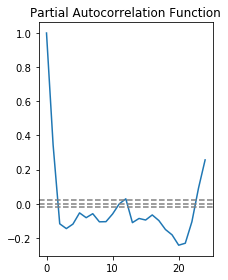

In [196]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(S1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(S1_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [197]:
from statsmodels.tsa.arima_model import ARIMA

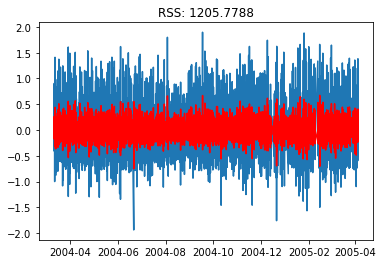

In [198]:
model = ARIMA(S1_log_diff, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(S1_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-S1_log_diff)**2))
# Prediction
#strt_date = pd.to_datetime('2014-01-01 01:00:00')
#end_date = pd.to_datetime('2050-01-01 01:00:00')
#Var_pred = results.predict(start = strt_date, end = end_date, typ = tp) 
#Var_pred 


In [199]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)


In [200]:
predictions_AR_diff.head()

2004-03-10 19:00:00    0.000005
2004-03-10 20:00:00   -0.080789
2004-03-10 21:00:00    0.010833
2004-03-10 22:00:00    0.014856
2004-03-10 23:00:00   -0.136785
dtype: float64

In [201]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_diff_cumsum.head()

2004-03-10 19:00:00    0.000005
2004-03-10 20:00:00   -0.080784
2004-03-10 21:00:00   -0.069951
2004-03-10 22:00:00   -0.055095
2004-03-10 23:00:00   -0.191880
dtype: float64

In [202]:
predictions_AR_log = pd.Series(S1_log.ix[0], index=S1_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

2004-03-10 18:00:00    2.475001
2004-03-10 19:00:00    2.475007
2004-03-10 20:00:00    2.394218
2004-03-10 21:00:00    2.405050
2004-03-10 22:00:00    2.419906
dtype: float64

In [203]:
predictions_AR = np.exp(predictions_AR_log)
predictions_AR = pd.DataFrame(predictions_AR)

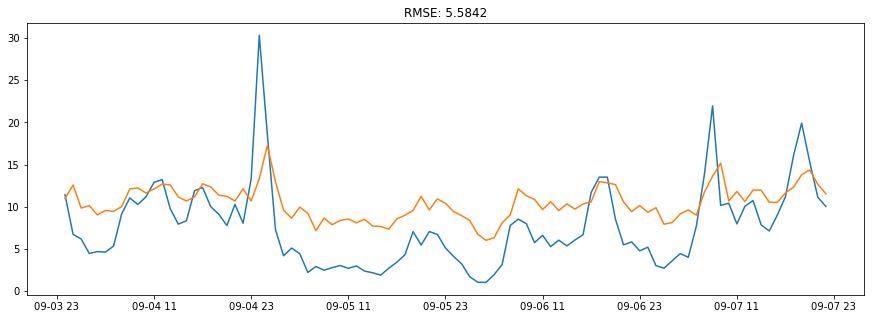

In [205]:
predictions_AR = np.exp(predictions_AR_log)
plt.figure(figsize=(15,5))
plt.plot(S1['2004-09-04':'2004-09-07'])
plt.plot(predictions_AR['2004-09-04':'2004-09-07'])
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_AR-S1)**2)/len(S1)))

In [94]:
test_df = pd.read_csv("test (4).csv")
test_df.shape

(2773, 12)